In [1]:
# Step 1: Mount Google Drive for File Access
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Step#1** establishes a connection between your Google Colab environment and your Google Drive so the notebook can access datasets, scripts, and output files stored there. The code imports the drive module from google.colab and mounts your Drive at the path /content/drive, which makes your Drive behave like a local filesystem inside Colab. If the Drive is already mounted, Colab simply notifies you and suggests using force_remount=True if you need to refresh the connection. This step is foundational because it ensures all subsequent workflow steps can reliably read and write files.

In [2]:
# Step 2: Load preprocessed dataset
import pandas as pd

df = pd.read_csv(
    '/content/drive/MyDrive/prostate_cancer_prediction_cleaned_imputed.csv'
)

df.head()

,Patient_ID,Age,Family_History,Race_African_Ancestry,PSA_Level,DRE_Result,Biopsy_Result,Difficulty_Urinating,Weak_Urine_Flow,Blood_in_Urine,...,Alcohol_Consumption,Hypertension,Diabetes,Cholesterol_Level,Screening_Age,Follow_Up_Required,Prostate_Volume,Genetic_Risk_Factors,Previous_Cancer_History,Early_Detection
0,1,78,No,Yes,5.07,Normal,Benign,No,No,No,...,Moderate,No,No,Normal,45,No,46.0,No,No,Yes
1,2,68,No,Yes,10.24,Normal,Benign,Yes,No,No,...,Low,No,No,High,65,No,78.2,No,No,Yes
2,3,54,No,No,13.79,Normal,Benign,No,No,No,...,Low,No,No,Normal,61,No,21.1,No,No,Yes
3,4,82,No,No,8.03,Abnormal,Benign,No,No,No,...,Low,No,No,Normal,47,Yes,79.9,No,Yes,Yes
4,5,47,Yes,No,1.89,Normal,Malignant,Yes,Yes,No,...,Moderate,Yes,No,Normal,72,No,32.0,No,No,Yes


In [ ]:
# Step 3: Install and Import Survival Analysis Tools
!pip install lifelines

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt


**Step#3** prepares the Colab environment for survival analysis by installing and importing the necessary Python libraries. It begins by installing the lifelines package, which provides tools for modeling and visualizing survival data. The output confirms that all dependencies—such as numpy, pandas, matplotlib, and autograd—are already satisfied. After installation, the code imports KaplanMeierFitter from lifelines for estimating survival functions, and matplotlib.pyplot for plotting. This step ensures that the environment is equipped to perform Kaplan-Meier survival analysis on clinical data, a key technique for understanding time-to-event outcomes in medical research.

In [ ]:
# Step 4 Create 5‑Year Survival Event Variable

df['Event_5_Years'] = df['Survival_5_Years'].apply(lambda x: 1 if x == 'No' else 0)
display(df[['Survival_5_Years', 'Event_5_Years']].head())

,Survival_5_Years,Event_5_Years
0,Yes,0
1,Yes,0
2,Yes,0
3,Yes,0
4,Yes,0


**Step#4** converts the categorical 5‑year survival outcome into a numerical event indicator required for survival analysis. The code creates a new column, Event_5_Years, by applying a lambda function to the existing Survival_5_Years column: patients labeled "No" (meaning they did not survive 5 years) are assigned a value of 1, indicating an event occurred, while all other values—typically "Yes"—are mapped to 0, indicating no event. Displaying the two columns side‑by‑side helps verify that the transformation is correct. This step is essential because survival models such as Kaplan‑Meier require a binary event variable rather than text labels.

In [ ]:
# Step 5 Inspect Dataset Column Names

print(df.columns.tolist())

['Patient_ID', 'Age', 'Family_History', 'Race_African_Ancestry', 'PSA_Level', 'DRE_Result', 'Biopsy_Result', 'Difficulty_Urinating', 'Weak_Urine_Flow', 'Blood_in_Urine', 'Pelvic_Pain', 'Back_Pain', 'Erectile_Dysfunction', 'Cancer_Stage', 'Treatment_Recommended', 'Survival_5_Years', 'Exercise_Regularly', 'Healthy_Diet', 'BMI', 'Smoking_History', 'Alcohol_Consumption', 'Hypertension', 'Diabetes', 'Cholesterol_Level', 'Screening_Age', 'Follow_Up_Required', 'Prostate_Volume', 'Genetic_Risk_Factors', 'Previous_Cancer_History', 'Early_Detection', 'Event_5_Years']


**Step#5** prints the full list of column names in the DataFrame so you can quickly review the structure of the dataset and confirm which variables are available for analysis. By calling df.columns.tolist(), the code converts the DataFrame’s column index into a standard Python list, making it easy to scan through feature names such as demographic variables, clinical measurements, and symptom indicators. This step is especially useful before selecting variables for modeling, cleaning, or visualization, ensuring you have a clear understanding of the dataset’s schema.

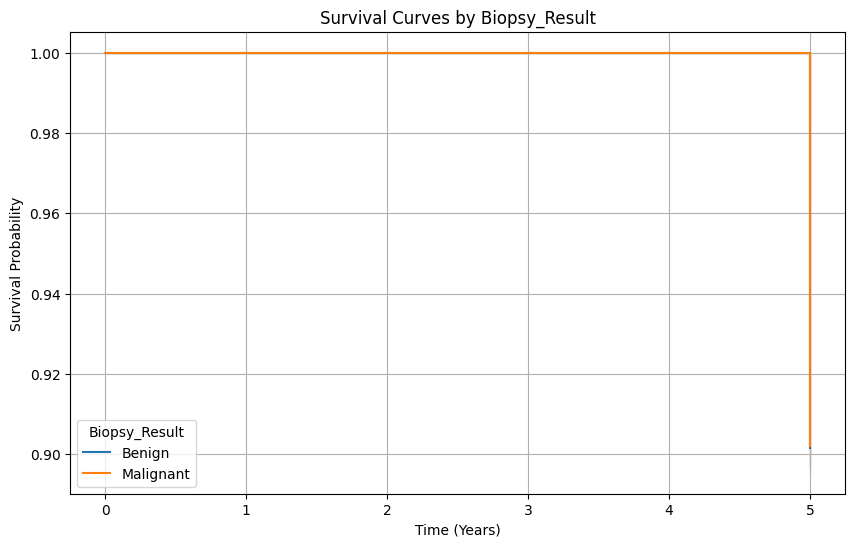

In [ ]:
# Step 6: Kaplan-Meier survival curves for stratified groups

# Replace this with your actual stratification column
group_col = 'Biopsy_Result' # Changed from 'treatment_group' to an existing column

groups = df[group_col].unique()

# Survival time and event indicator columns
# For 5-year survival, if no continuous time column is available, we set time to 5 years.
T = pd.Series([5] * len(df))   # Survival time is fixed at 5 years for all observations
E = df['Event_5_Years']   # Event occurred (1=No Survival_5_Years, 0=Yes Survival_5_Years)

plt.figure(figsize=(10, 6))

for group in groups:
    ix = df[group_col] == group
    kmf = KaplanMeierFitter()
    kmf.fit(T[ix], event_observed=E[ix], label=str(group))
    kmf.plot_survival_function()

plt.title(f'Survival Curves by {group_col}')
plt.xlabel('Time (Years)')
plt.ylabel('Survival Probability')
plt.legend(title=group_col)
plt.grid(True)
plt.show()

**Step#6** creates Kaplan–Meier survival curves stratified by a chosen grouping variable—in this case, Biopsy_Result—to visually compare survival probabilities between clinical subgroups. The code identifies each unique group, sets a fixed survival time of 5 years for all patients (since no continuous time‑to‑event variable is available), and uses the previously created binary event indicator to mark whether a patient did or did not survive the 5‑year period. For each group, a KaplanMeierFitter model is fit and plotted, producing survival curves that reveal differences in outcomes between “Benign” and “Malignant” biopsy results. This step is essential for understanding how survival patterns vary across clinically meaningful categories.

In [ ]:
# Step 7: Save Kaplan–Meier Plot to Drive
import os

output_dir = '/content/drive/MyDrive/projects/prostate_cancer/results/'
os.makedirs(output_dir, exist_ok=True)

plt.savefig(os.path.join(output_dir, 'km_stratified_plot.png'), dpi=300)

<Figure size 640x480 with 0 Axes>

**Step#7** handles the process of saving the generated Kaplan–Meier survival plot to your Google Drive so it can be stored, shared, or included in reports. The code first imports the os module, defines an output directory within your project folder, and ensures that the directory exists by creating it if necessary. It then saves the current Matplotlib figure as km_stratified_plot.png with a high‑resolution setting of 300 dpi. This step formalizes the workflow by ensuring that visual outputs are consistently saved in an organized location, supporting reproducibility and clean project structure.